# Titanic

### TODO add a read me

### 1. Preparing the data

First import necessary modules

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer

Please modify these paths before running your code. <br> In defeault the csv files should be in under Data folder

In [2]:
train_path = "Data" + os.sep + "train.csv"
test_input_path = "Data" + os.sep + "test.csv"
test_output_path = "Data" + os.sep + "gender_submission.csv"

Reading train and test files

In [3]:
train_dataset = pd.read_csv(train_path)
test_input_dataset = pd.read_csv(test_input_path)
test_output_dataset = pd.read_csv(test_output_path)

Let's understand the data

In [4]:
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Before countinue lets seperate our survived from training set

In [5]:
train_target = train_dataset[["Survived"]]
train_dataset.drop("Survived", axis=1, inplace=True)

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


First i want to deal with null inputs lets see if there is any

In [7]:
train_dataset.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Wow ok.. There is 889 input data and Cabin has 687 null data i think it is best to discard this feature

In [8]:
unnecessary_features = ["Cabin"]

In [9]:
train_dataset[["Name","Ticket"]]

,Name,Ticket
0,"Braund, Mr. Owen Harris",A/5 21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599
2,"Heikkinen, Miss. Laina",STON/O2. 3101282
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803
4,"Allen, Mr. William Henry",373450
...,...,...
886,"Montvila, Rev. Juozas",211536
887,"Graham, Miss. Margaret Edith",112053
888,"Johnston, Miss. Catherine Helen ""Carrie""",W./C. 6607
889,"Behr, Mr. Karl Howell",111369


In [10]:
train_dataset["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [11]:
train_dataset["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

I can not think any transformation for ticket and name and for now i am going to drop them

In [12]:
unnecessary_features.append("Name")
unnecessary_features.append("Ticket")

In [13]:
def drop_features(dataframe, features):
    dataframe.drop(features, axis=1, inplace=True, errors="ignore")

In [14]:
drop_features(train_dataset, unnecessary_features)

Ok now lets focus on Age feature lets examine this feature

<Axes: ylabel='Frequency'>

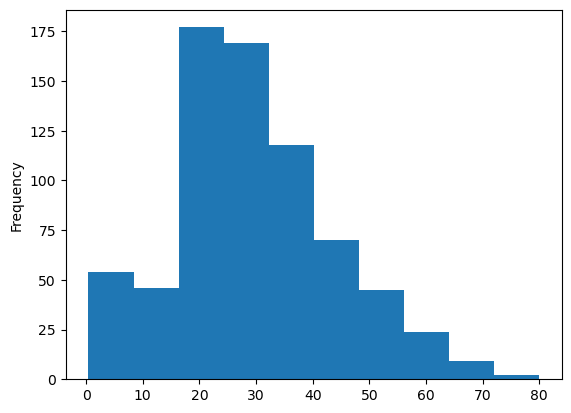

In [15]:
train_dataset["Age"].plot(kind="hist")

I think it is best to fill with mean value

In [16]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [17]:
train_dataset.select_dtypes(include=['number'])

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500
...,...,...,...,...,...,...
886,887,2,27.0,0,0,13.0000
887,888,1,19.0,0,0,30.0000
888,889,3,NaN,1,2,23.4500
889,890,1,26.0,0,0,30.0000


In [18]:
all_imputers_features = []  # I am going to use this variable later on for making things more easier when we encounter unproper dataset
imputer_numeric = SimpleImputer(strategy='mean')
train_dataset[train_dataset.select_dtypes(include=['number']).columns] = imputer_numeric.fit_transform(train_dataset.select_dtypes(include=['number']))
all_imputers_features.append([imputer_numeric, train_dataset.select_dtypes(include=['number']).columns])

Lastly we need to check our Embarked fature lets examine that columns

In [19]:
train_dataset["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

I am going to fill na values with most seen one S 

In [20]:
train_dataset.select_dtypes(include=['object']).columns

Index(['Sex', 'Embarked'], dtype='object')

In [21]:
imputer_most_frequent = SimpleImputer(strategy='most_frequent')
train_dataset[train_dataset.select_dtypes(include=['object']).columns] = imputer_most_frequent.fit_transform(train_dataset.select_dtypes(include=['object']))
all_imputers_features.append([imputer_most_frequent,train_dataset.select_dtypes(include=['object']).columns])

Ok so we do not now which features are empty in test so i want to do imputer for all features and it will be mean
but we can not apply mean for non numeric features for them we will do most_frequent 

In [22]:
def impute(dataframe, inputers_features):
    for _, imputer_feature in enumerate(inputers_features):
        dataframe[imputer_feature[1]] = imputer_feature[0].transform(dataframe[imputer_feature[1]])

In [23]:
impute(train_dataset, all_imputers_features)

Ok now lets see what is our columns data types

In [24]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    float64
 1   Pclass       891 non-null    float64
 2   Sex          891 non-null    object 
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    float64
 5   Parch        891 non-null    float64
 6   Fare         891 non-null    float64
 7   Embarked     891 non-null    object 
dtypes: float64(6), object(2)
memory usage: 55.8+ KB


First lets look at Sex object

Ok interesting we only got two. lets one hot encode it

Now lets look at Embarked feature again for encoding it

In [25]:
train_dataset["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

Lets write a encoder function so we can call this function again and again for traning and testing

In [26]:
all_encoders_features = [[OneHotEncoder(handle_unknown="error"), ["Sex","Embarked"]]]  # It looks like we will have only one ecoder but lets do it like that for readability and maintainability
all_encoders_features[0][0].fit(train_dataset[["Sex","Embarked"]])
# Notice that we did not apply transform because
# One hot encoding requires few steps therefore we
# will write a function for that

OneHotEncoder()

In [27]:
def encode(dataframe, encoders_features):
    for _, encoder_feature in enumerate(encoders_features):
        encoded_array = encoder_feature[0].transform(dataframe[encoder_feature[1]]).toarray().astype('int32')  
        # It returns float64 i want int32
        # We already fit the encoder for our training data we only need to transform
        dataframe.drop(encoder_feature[1], axis=1, inplace=True)
        encoded_dataframe = pd.DataFrame(encoded_array, columns=encoder_feature[0].get_feature_names_out())
        dataframe = pd.concat([dataframe, encoded_dataframe], axis=1)
    return dataframe

In [28]:
all_encoders_features

[[OneHotEncoder(), ['Sex', 'Embarked']]]

In [29]:
train_dataset = encode(train_dataset, all_encoders_features)  # Yes, i know it only has one but it is nice practice i think

Let's check it

In [30]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    float64
 1   Pclass       891 non-null    float64
 2   Age          891 non-null    float64
 3   SibSp        891 non-null    float64
 4   Parch        891 non-null    float64
 5   Fare         891 non-null    float64
 6   Sex_female   891 non-null    int32  
 7   Sex_male     891 non-null    int32  
 8   Embarked_C   891 non-null    int32  
 9   Embarked_Q   891 non-null    int32  
 10  Embarked_S   891 non-null    int32  
dtypes: float64(6), int32(5)
memory usage: 59.3 KB


In [31]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    float64
 1   Pclass       891 non-null    float64
 2   Age          891 non-null    float64
 3   SibSp        891 non-null    float64
 4   Parch        891 non-null    float64
 5   Fare         891 non-null    float64
 6   Sex_female   891 non-null    int32  
 7   Sex_male     891 non-null    int32  
 8   Embarked_C   891 non-null    int32  
 9   Embarked_Q   891 non-null    int32  
 10  Embarked_S   891 non-null    int32  
dtypes: float64(6), int32(5)
memory usage: 59.3 KB


## Feature Scaling

Now everythink is numerical what we need to do feature scaling but beacuse of not every ML model required feature scaling we will take copy and move on and lets make a all_scalers variable for reuse it again and again

In [32]:
train_dataset_scaled = train_dataset.copy()
all_scalers_features = []

Let's see our features histogram bars we do not need to scale encoded features so i am going to draw histogram just for the rest

array([[<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'PassengerId'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

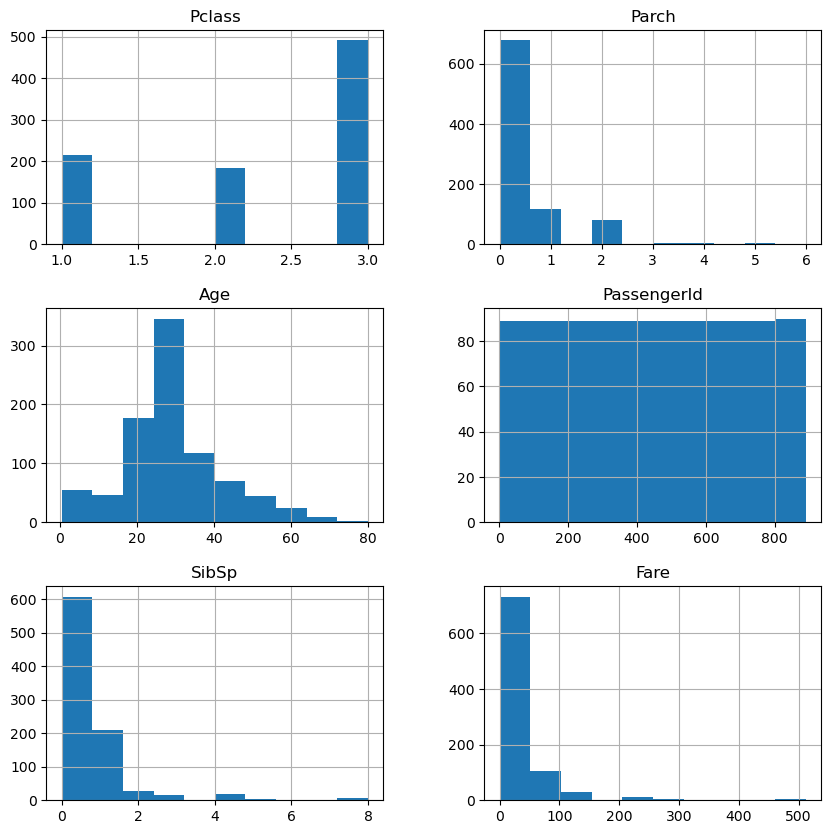

In [33]:
ft = {feature for encoder in all_encoders_features for feature in encoder[0].get_feature_names_out() }  # TODO BURADA KALDIK
columns_to_scale = list(set(train_dataset_scaled.columns) - ft)
train_dataset_scaled[columns_to_scale].hist(figsize=(10, 10))

Lets do minmax scaling for PassengerId beacuse it is nicesquare shaped every Id has a equal probability

I want this range for 0 to 1 from 0 to 1 i want it beacuse one hot encoding does it scaling 0 to 1 #TODO burayı adam gibi yaz saçma oldu

In [34]:
minmaxscaler_passengerid = MinMaxScaler(feature_range=(0, 1))
all_scalers_features.append([minmaxscaler_passengerid, ["PassengerId"]])


For age lets do standart normalization

In [35]:
standardscaler_age = StandardScaler()
all_scalers_features.append([standardscaler_age, ["Age"]])

I want to scale Fare too if the model will perform badly we will do more scaling and improve some scalers

In [36]:
logscaler_fare = FunctionTransformer(lambda x: np.log(x+1))
all_scalers_features.append([logscaler_fare, "Fare"])

In [37]:
for _, scaler_feature in enumerate(all_scalers_features):
    scaler_feature[0].fit(train_dataset_scaled[scaler_feature[1]])


Let's define a scaler method for making it more nice

In [38]:
def scaler(dataframe, scalers_and_feature):
    for _, scaler_feature in enumerate(scalers_and_feature):
        dataframe[scaler_feature[1]] = scaler_feature[0].transform(dataframe[scaler_feature[1]])

In [39]:
scaler(train_dataset_scaled, all_scalers_features)

In [40]:
train_target

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


### Preparing test data

Lets drop unnecessary columns first

In [41]:
drop_features(test_input_dataset, unnecessary_features)

test_input_dataset

Lets fill the null values

In [42]:
impute(test_input_dataset, all_imputers_features)

In [43]:
test_input_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    float64
 1   Pclass       418 non-null    float64
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    float64
 5   Parch        418 non-null    float64
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    object 
dtypes: float64(6), object(2)
memory usage: 26.2+ KB


Let's encode them

In [44]:
test_input_dataset = encode(test_input_dataset, all_encoders_features)

In [45]:
test_input_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    float64
 1   Pclass       418 non-null    float64
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    float64
 4   Parch        418 non-null    float64
 5   Fare         418 non-null    float64
 6   Sex_female   418 non-null    int32  
 7   Sex_male     418 non-null    int32  
 8   Embarked_C   418 non-null    int32  
 9   Embarked_Q   418 non-null    int32  
 10  Embarked_S   418 non-null    int32  
dtypes: float64(6), int32(5)
memory usage: 27.9 KB


In [46]:
scaler(test_input_dataset, all_scalers_features)

In [47]:
test_input_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    float64
 1   Pclass       418 non-null    float64
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    float64
 4   Parch        418 non-null    float64
 5   Fare         418 non-null    float64
 6   Sex_female   418 non-null    int32  
 7   Sex_male     418 non-null    int32  
 8   Embarked_C   418 non-null    int32  
 9   Embarked_Q   418 non-null    int32  
 10  Embarked_S   418 non-null    int32  
dtypes: float64(6), int32(5)
memory usage: 27.9 KB


# Training The Model

## Logistic Regression


Logistic Regression is a simple classification model the model tries to find a line that seperates the training instances then if a instance is below the line then it does classify as a positive class otherwise negative class.

In [48]:
test_output = test_output_dataset["Survived"].values.ravel()  # ravel converts multidimensional arrays to 1 d we will need this
train_output = train_target.values.ravel() # For simplyfing

In [49]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42) # For this project we will always use random_state 42 for determitzm
log_reg.fit(train_dataset_scaled, train_output)

LogisticRegression(random_state=42)

In [50]:
estimators = [("log_reg", log_reg)] # This will bu usefull for ensemble methods

In [51]:
best_model = log_reg
best_score = log_reg.score(test_input_dataset, test_output)

In [52]:
best_score

0.930622009569378

Not so bad for the first try and with no reqularization or even hypermeter tunning 

## Suppor Vector Machine Classification (SVM Classification) (SVC)

Well SVMs have very different versions but we will just do linear SVC

### Linear SVC

In [54]:
from sklearn.svm import SVC

linear_svc_reg = SVC(random_state=42)
linear_svc_reg.fit(train_dataset_scaled, train_output)
current_score = linear_svc_reg.score(test_input_dataset, test_output)

estimators.append(("linear_svc_reg", linear_svc_reg))

if current_score > best_score:
    best_score = current_score
    best_model = linear_svc_reg
print(current_score)    

0.9593301435406698


Wow wow wow very nice improvment notice that we did not even use any hyperparameters

## Decision Tree Classifier

In [55]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(train_dataset_scaled, train_output)
current_score = decision_tree_classifier.score(test_input_dataset, test_output)

estimators.append(("decision_tree_classifier", decision_tree_classifier))

if current_score > best_score:
    best_score = current_score
    best_model = linear_svc_reg
print(current_score)    

0.8110047846889952


Decision tress resulted as a worst score then rest of them but lets look at his brother RandomForest Classifier

## Random Forest Classifier

In [56]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(train_dataset_scaled, train_output)
current_score = random_forest_classifier.score(test_input_dataset, test_output)

estimators.append(("random_forest_classifier", random_forest_classifier))

if current_score > best_score:
    best_score = current_score
    best_model = linear_svc_reg
print(current_score) 

0.7511961722488039


Well it turns out it is even worst but stick to the plan

## KNN Classifier

In [57]:
from sklearn.neighbors import KNeighborsClassifier

k_neighbors_classifier = KNeighborsClassifier()
k_neighbors_classifier.fit(train_dataset_scaled, train_output)
current_score = k_neighbors_classifier.score(test_input_dataset, test_output)

estimators.append(("k_neighbors_classifier", k_neighbors_classifier))

if current_score > best_score:
    best_score = current_score
    best_model = linear_svc_reg
print(current_score) 

0.8157894736842105


## Voting Classifier

In [58]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(estimators=estimators)
voting_classifier.fit(train_dataset_scaled, train_output)
current_score = voting_classifier.score(test_input_dataset, test_output)

if current_score > best_score:
    best_score = current_score
    best_model = linear_svc_reg
print(current_score) 

0.8971291866028708


In this part even we found good solutions like 0.95 accuracy this is not enough and we can do so much improvements
Like we did not tuned hyperparameters or we can use boosting if does not improves too we can use klustering algorithms and 
found outliers and eliminate them and train again.

## Tunning HyperParameters

For searching for a nice parameters we can use 3 major search algorithm grid search, random search, and Bayesian optimization. We will use all of them for showing how to use them